In [1]:
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import podpac

# PODPAC Data Library

The PODPAC data library contains a library of pre-wrapped data sources. These data sources can then be easily accessed programatically. As an example, we have wrapped some of the SMAP products. 

## SMAP DataSource Example

In [3]:
from podpac import datalib
from podpac.datalib import smap

datalib.smap.SMAP_PRODUCT_MAP.product.data.tolist()

['SPL4SMAU.003', 'SPL4SMGP.003', 'SPL3SMA.003', 'SPL3SMAP.003', 'SPL3SMP.004']

In [4]:
product = datalib.smap.SMAP_PRODUCT_MAP.product[0].item()
product

'SPL4SMAU.003'

In [5]:
smap = datalib.smap.SMAP(product=product, interpolation='nearest_preview')
# The available coordinates are built from all available SMAP sources for this product
# This requires multiple http get requests from the DAAC OpenDAP server, and may take a while
# Because of this, the results are cached after the first run
smap.native_coordinates  

<class 'podpac.core.coordinate.Coordinate'>
	time: Coord: Bounds[2015-03-31T03:00:00, 2017-10-16T00:00:00], N[7440], ctype["segment"]
	lat: Coord: Bounds[-84.65644073486328, 84.65644073486328], N[1624], ctype["segment"]
	lon: Coord: Bounds[-179.95474243164062, 179.95474243164062], N[3856], ctype["segment"]

A data source's `native_coordinates` describes the "coverage" of the data, that is, it gives the lat,lon coordinates and times for which the data is available. Thus, the data is natively available for those coordinates.

However, a user may request any coordinates, and PODPAC will do the requested interpolation. This will happen without downloading the entire dataset, or any manual data wrangling

(181, 361, 1)


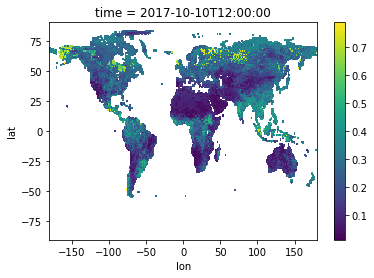

In [6]:
coordinates = podpac.Coordinate(lat=(-90, 90, 1.), lon=(-180, 180, 1.), time='2017-10-10T12:00:00', 
                               order=['lat', 'lon', 'time'])
output = smap.execute(coordinates)
print (output.shape)
output[..., 0].plot()

(91, 361, 1)


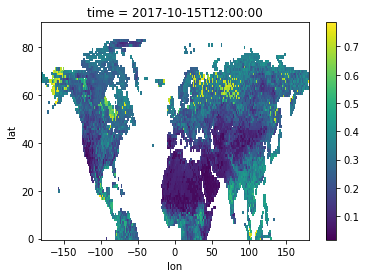

In [7]:
figure()
coordinates = podpac.Coordinate(lat=(0., 90, 1.), lon=(-180, 180, 1.), time='2017-10-15T12:00:00', 
                               order=['lat', 'lon', 'time'])
output = smap.execute(coordinates)
print (output.shape)
output[..., 0].plot()

(1, 1, 61)


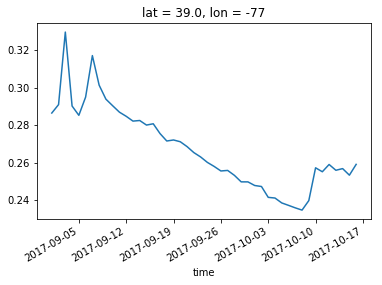

In [9]:
figure()
coordinates = podpac.Coordinate(lat=39., lon=-77, time=('2017-09-01', '2017-10-31', '1,D'), 
                               order=['lat', 'lon', 'time'])
output = smap.execute(coordinates)
print (output.shape)
output.plot()

In [10]:
# We can also look at what other layers are available for this SMAP product
sm = smap.sources[0].sources[0]
print( str(sm.dataset.keys()).replace(',', '\n'))

KeysView(<DatasetType with children 'Forecast_Data_sm_surface_forecast'
 'Forecast_Data_tb_v_forecast'
 'Forecast_Data_surface_temp_forecast'
 'Forecast_Data_tb_v_forecast_ensstd'
 'Forecast_Data_soil_temp_layer1_forecast'
 'Forecast_Data_sm_profile_forecast'
 'Forecast_Data_tb_h_forecast'
 'Forecast_Data_sm_rootzone_forecast'
 'Forecast_Data_tb_h_forecast_ensstd'
 'time'
 'Analysis_Data_sm_surface_analysis_ensstd'
 'Analysis_Data_surface_temp_analysis_ensstd'
 'Analysis_Data_sm_rootzone_analysis_ensstd'
 'Analysis_Data_sm_surface_analysis'
 'Analysis_Data_sm_profile_analysis_ensstd'
 'Analysis_Data_sm_rootzone_analysis'
 'Analysis_Data_sm_profile_analysis'
 'Analysis_Data_soil_temp_layer1_analysis'
 'Analysis_Data_soil_temp_layer1_analysis_ensstd'
 'Analysis_Data_surface_temp_analysis'
 'cell_row'
 'cell_column'
 'Observations_Data_tb_v_obs'
 'Observations_Data_tb_v_obs_time_sec'
 'Observations_Data_tb_h_obs'
 'Observations_Data_tb_h_orbit_flag'
 'Observations_Data_tb_h_resolution_fla

## SMAP Implementation Details
The SMAP data can be accessed from and OpenDAP server from a NASA DAAC. The data is organized in a folders, where each folder represents a day. Inside each folder, there are multiple files for different times of the day. Or:
* SMAP
    * YYYY.MM.DD
        * YYYY.MM.DD-HH:mm:ss
        * YYYY.MM.DD-HH:mm:ss
        * ...
    * ...
    * YYYY.MM.DD
        * YYYY.MM.DD-HH:mm:ss
        * YYYY.MM.DD-HH:mm:ss
        * ...
    

The SMAP data source organizes the data in the same way. In fact, the SMAP node composites multiple SMAPDateFolder's, which each composites multiple SMAPSource nodes.

In [11]:
print(smap.sources[:3])
print(smap.source_coordinates.coords['time'][:3])

['2015-03-31' '2015-04-01' '2015-04-02']


In [12]:
print(smap.sources[2].sources)
print(smap.sources[2].source_coordinates)

<class 'podpac.core.coordinate.Coordinate'>
	time: Coord: Bounds[2015-04-02T03:00:00, 2015-04-03T00:00:00], N[8], ctype["segment"]


In [13]:
print(smap.sources[2].sources[3])
print(smap.sources[2].sources[3].native_coordinates)

<class 'podpac.core.coordinate.Coordinate'>
	lat: Coord: Bounds[-84.65644073486328, 84.65644073486328], N[1624], ctype["segment"]
	lon: Coord: Bounds[-179.95474243164062, 179.95474243164062], N[3856], ctype["segment"]
	time: Coord: Bounds[2015-04-02T11:59:59, 2015-04-02T12:00:01], N[1], ctype["segment"]


PODPAC provides an `OrderedCompositor` node to allow this nested structure to be easily implemented. 

In [14]:
smap.__class__.__bases__

(podpac.core.compositor.OrderedCompositor,)

PODPAC provides a PyDAP data type for wrapping OpenDAP data sources:

In [15]:
smap.sources[0].sources[0].__class__.__bases__

(podpac.core.data.type.PyDAP,)

# Standard PODPAC data types
PODPAC provides multiple standard base data types that can be used to wrap new data sources.

In [16]:
print ([t for t in dir(podpac.core.data.type) 
      if '_' not in t and t[0].isupper() and t not in ['BytesIO', 'OrderedDict', 'UnitRegistry']])

['NumpyArray', 'PyDAP', 'RasterioSource', 'ReprojectedSource', 'WCS']


# Standard PODPAC algorithms
PODPAC provides a few standard algorithms as well

In [17]:
print ([t for t in dir(podpac.core.algorithm.algorithm) 
      if '_' not in t and t[0].isupper() and t not in ['Coordinate', 'Node', 'UnitsDataArray', "OrderedDict", 'UnitRegistry']])

['Algorithm', 'Arithmetic', 'SinCoords']


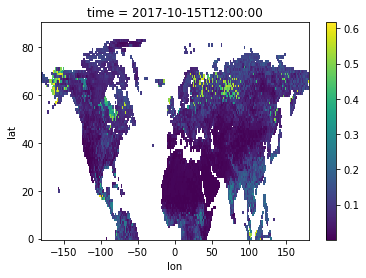

In [19]:
# Implementing an algorithm is simple
# As an example, let's square some data
class Square(podpac.Algorithm):
    node = podpac.core.node.tl.Instance(podpac.Node)
    
    def algorithm(self, node):
        return node ** 2
    
s = Square(node=smap)
coordinates = podpac.Coordinate(lat=(0., 90, 1.), lon=(-180, 180, 1.), time='2017-10-15T12:00:00', 
                               order=['lat', 'lon', 'time'])
output = s.execute(coordinates)
figure()
output[..., 0].plot()